<a href="https://colab.research.google.com/github/ebuehrle/polyssimo/blob/main/polyssimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import jax
import jax.numpy as jnp
import functools

In [219]:
@functools.partial(jax.vmap, in_axes=(None, 0)) # pieces
@functools.partial(jax.vmap, in_axes=(None, 0)) # rotations
def placements(board, piece):
  board_height, board_width = board.shape
  piece_height, piece_width = piece.shape

  padded_board = jnp.pad(
      board,
      ((0, piece_height - 1), (0, piece_width - 1)),
      constant_values=1
  )

  places = 1.0 * (jax.lax.conv(
      padded_board[jnp.newaxis, jnp.newaxis, :, :],
      piece[jnp.newaxis, jnp.newaxis, :, :],
      (1, 1),
      'VALID'
  )[0, 0, :, :] == 0)

  return places

@jax.vmap # pieces
@jax.vmap # rotations
def coverage(piece, placements):
  board_height, board_width = placements.shape
  piece_height, piece_width = piece.shape

  padded_placements = jnp.pad(
      placements,
      ((piece_height - 1, 0), (piece_width - 1, 0)),
      constant_values=0
  )
  flipped_piece = jnp.flip(piece)
  cov = jax.lax.conv(
      padded_placements[jnp.newaxis, jnp.newaxis, :, :],
      flipped_piece[jnp.newaxis, jnp.newaxis, :, :],
      (1, 1),
      'VALID'
  )[0, 0, :, :]

  return cov

def solve(board, pieces, unique_rotations, idx=0):
  _, board_height, board_width = board.shape
  num_pieces, num_rotations, pcs_height, pcs_width = pieces.shape

  current_board = jnp.sum(board[:idx+1], axis=0)
  if idx >= num_pieces or jnp.all(current_board):
    return board

  # compute placements and coverage for remaining pieces
  remaining_pieces = pieces[idx:, :, :, :]
  remaining_unique_rotations = unique_rotations[idx:, :]
  piece_placements = placements(current_board, remaining_pieces) * remaining_unique_rotations[:, :, jnp.newaxis, jnp.newaxis]
  piece_coverage = coverage(remaining_pieces, piece_placements) * remaining_unique_rotations[:, :, jnp.newaxis, jnp.newaxis]

  # if cannot place all remaining pieces -> stop
  all_pieces_placeable = jnp.all(jnp.any(piece_placements, axis=(1, 2, 3)))
  if not all_pieces_placeable:
    return

  # if cannot cover entire board -> stop
  entire_board_coverable = jnp.all(current_board + jnp.sum(piece_coverage, axis=(0, 1)))
  if not entire_board_coverable:
    return

  # swap piece with fewest placements to the front
  coverage_per_piece = jnp.any(piece_coverage, axis=1)
  cell_coverage = jnp.sum(coverage_per_piece, axis=0)
  cell_coverage_by_piece = cell_coverage[jnp.newaxis, jnp.newaxis, :, :] * piece_coverage
  forced_pieces = jnp.argwhere(cell_coverage_by_piece == 1)

  if len(forced_pieces):
    next_piece_offset, _, _, _ = forced_pieces[0]
  else:
    total_coverage_per_piece = jnp.sum(coverage_per_piece, axis=(1, 2))
    piece_size = jnp.sum(remaining_pieces[:, 0, :, :], axis=(1, 2))
    next_piece_offset = jnp.argmin(total_coverage_per_piece - piece_size)
  
  def swap(arr, idx0, idx1):
    if idx0 == idx1: return arr
    a = arr[idx0]
    b = arr[idx1]
    arr = jax.ops.index_update(arr, idx0, b)
    arr = jax.ops.index_update(arr, idx1, a)
    return arr
  
  pieces = swap(pieces, idx, idx + next_piece_offset)
  unique_rotations = swap(unique_rotations, idx, idx + next_piece_offset)
  remaining_pieces = swap(remaining_pieces, 0, next_piece_offset)
  remaining_unique_rotations = swap(remaining_unique_rotations, 0, next_piece_offset)
  piece_placements = swap(piece_placements, 0, next_piece_offset)
  # TODO: sort placements by min coverage of touched board cells (lower -> higher priority)

  # for all placements of next piece -> place piece and recurse with updated board and idx+1
  for r in range(4):
    if not remaining_unique_rotations[0, r]:
      continue      

    next_piece = remaining_pieces[0, r, :, :]
    mask = jnp.zeros((board_height, board_width))
    mask = jax.ops.index_update(mask, jax.ops.index[:pcs_height, :pcs_width], next_piece)

    for i in range(board_height):
      for j in range(board_width):
        if piece_placements[0, r, i, j]:
          board = jax.ops.index_add(board, idx + 1, mask)
          res = solve(board, pieces, unique_rotations, idx + 1)
          if res is not None:
            return res
          board = jax.ops.index_add(board, idx + 1, -mask)
        mask = jnp.roll(mask, 1, axis=1)
      mask = jnp.roll(mask, 1, axis=0)

In [220]:
def align_top(mask):
  while not jnp.any(mask[0, :]):
    mask = jnp.roll(mask, -1, axis=0)
  return mask

def align_left(mask):
  return jnp.transpose(align_top(jnp.transpose(mask)))

align = lambda mask: align_left(align_top(mask))

def pc_rotations(piece):
  r0 = align(jnp.rot90(piece, 0))
  r1 = align(jnp.rot90(piece, 1))
  r2 = align(jnp.rot90(piece, 2))
  r3 = align(jnp.rot90(piece, 3))
  piece_rotations = jnp.stack([r0, r1, r2, r3], axis=0)

  unique_rotations = 1.0 * jnp.array([
    True,
    not (jnp.array_equal(r1, r0)),
    not (jnp.array_equal(r2, r1) or jnp.array_equal(r2, r0)),
    not (jnp.array_equal(r3, r2) or jnp.array_equal(r3, r1) or jnp.array_equal(r3, r0)),
  ])

  return piece_rotations, unique_rotations

def rotations(pieces):
  # can't vmap pc_rotations because of align_top
  res = [pc_rotations(p) for p in pieces]
  rot = jnp.stack([rot for rot, _ in res])
  uni = jnp.stack([uni for _, uni in res])
  return rot, uni

def polyssimo(board, pieces):
  board_height, board_width = board.shape
  num_pieces, _, _ = pieces.shape

  board_history = jnp.concatenate([
      board[jnp.newaxis, :, :],
      jnp.zeros((num_pieces, board_height, board_width)),
  ], axis=0)

  piece_rotations, unique_rotations = rotations(pieces)

  return solve(board_history, 1.0 * piece_rotations, 1.0 * unique_rotations)

In [221]:
board_easy = jnp.array([
  [0, 0, 1],
  [0, 0, 0],
  [0, 0, 0],
])

pe1 = jnp.array([
  [1, 1, 0],
  [1, 1, 0],
  [0, 0, 0],
])

pe2 = jnp.array([
  [1, 0, 0],
  [1, 0, 0],
  [1, 1, 0],
])

pieces_easy = jnp.stack([pe1, pe2])

In [222]:
polyssimo(board_easy, pieces_easy)

DeviceArray([[[0., 0., 1.],
              [0., 0., 0.],
              [0., 0., 0.]],

             [[1., 1., 0.],
              [1., 1., 0.],
              [0., 0., 0.]],

             [[0., 0., 0.],
              [0., 0., 1.],
              [1., 1., 1.]]], dtype=float32)

In [223]:
board_medium = jnp.array([
  [0, 0, 1, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
])

pm1 = jnp.array([
  [0, 1, 0],
  [1, 1, 0],
  [1, 1, 0],
])

pm2 = jnp.array([
  [1, 1, 0],
  [1, 0, 0],
  [1, 0, 0],
])

pm3 = jnp.array([
  [1, 0, 0],
  [1, 0, 0],
  [1, 0, 0],
])

pm4 = jnp.array([
  [1, 0, 0],
  [1, 1, 0],
  [0, 0, 0],
])

pieces_medium = jnp.stack([pm1, pm2, pm3, pm4])

In [224]:
polyssimo(board_medium, pieces_medium)

DeviceArray([[[0., 0., 1., 0.],
              [0., 0., 0., 0.],
              [0., 0., 0., 0.],
              [0., 0., 0., 0.]],

             [[0., 0., 0., 1.],
              [0., 0., 1., 1.],
              [0., 0., 1., 1.],
              [0., 0., 0., 0.]],

             [[0., 0., 0., 0.],
              [0., 0., 0., 0.],
              [0., 1., 0., 0.],
              [0., 1., 1., 1.]],

             [[0., 0., 0., 0.],
              [1., 0., 0., 0.],
              [1., 0., 0., 0.],
              [1., 0., 0., 0.]],

             [[1., 1., 0., 0.],
              [0., 1., 0., 0.],
              [0., 0., 0., 0.],
              [0., 0., 0., 0.]]], dtype=float32)

In [236]:
board_hard = jnp.array([
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0],
  [0, 0, 1, 1, 1, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
])

ph1 = jnp.array([
  [1, 1, 0],
  [0, 1, 0],
  [0, 1, 1],
])

ph2 = jnp.array([
  [1, 1, 0],
  [1, 1, 0],
  [0, 1, 0],
])

ph3 = jnp.array([
  [1, 0, 0],
  [1, 1, 0],
  [0, 1, 0],
])

ph4 = jnp.array([
  [1, 0, 0],
  [1, 1, 0],
  [0, 1, 1],
])

ph5 = jnp.array([
  [0, 1, 0],
  [1, 1, 0],
  [0, 1, 1],
])

ph6 = jnp.array([
  [0, 1, 0],
  [0, 1, 0],
  [1, 1, 0],
])

ph7 = jnp.array([
  [1, 0, 0],
  [1, 0, 0],
  [1, 1, 0],
])

ph8 = jnp.array([
  [0, 1, 0],
  [1, 1, 1],
  [0, 0, 0],
])

ph9 = jnp.array([
  [1, 1, 0],
  [1, 1, 0],
  [0, 0, 0],
])

ph10 = jnp.array([
  [1, 1, 0],
  [1, 0, 0],
  [1, 1, 0],
])

ph11 = jnp.array([
  [0, 1, 0],
  [1, 1, 0],
  [1, 0, 0],
])

pieces_hard = jnp.stack([ph1, ph2, ph3, ph4, ph5, ph7, ph8, ph9, ph10, ph11])

In [237]:
sln_hard = polyssimo(board_hard, pieces_hard)

In [238]:
def steps(sln):
  sln_steps = len(sln)
  return jnp.sum(jnp.arange(sln_steps)[:, jnp.newaxis, jnp.newaxis] * sln, axis=0)

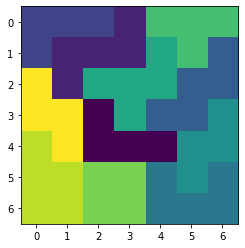

In [239]:
import matplotlib.pyplot as plt
plt.imshow(steps(sln_hard))